In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import random
import mutation
import crossover
import generator
import fitness
import plotting
import mainloop
#import pareto
import csv
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## 1. Parameters setting

In [12]:
# user given constants
src=0
dst=1
bandwidth_threshold = 2
# parameters
generation = 1000
max_depth = 5
k_shortest = 5
random_walk_mult = 2
generator_n = 25
generator_p = 0.1

In [13]:
random.seed(datetime.now())

## 2. Read input

In [14]:
#Read file related to testing
def get_test_file():
    '''Generator that return string of file name'''
    import re
    for files in os.listdir():
        if re.match('test.+\.csv', files) is not None:
            yield files
            
def csv_to_np(filename):
    return pd.read_csv(filename, header=None, delim_whitespace=True).values

# Use generator if file does not exist
generated_filename = 'generated' + str(generator_n) + ' ' + str(generator_p) + '.csv'
try:
    bandwidth_matrix = csv_to_np(generated_filename)
except:
    print('Generating new bandwidth matrix!!!!!!!!!!!')
    bandwidth_matrix = generator.generate("random", (1, 100), n=generator_n, p=generator_p).out(type="2d_list")
    with open(generated_filename, 'w') as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=' ')
        csvWriter.writerows(bandwidth_matrix)
else:
    print('Using existing generated matrix')

#bandwidth_matrix = csv_to_np('test1.csv')
#print(type(bandwidth_matrix), '\n', bandwidth_matrix)

Generating new bandwidth matrix!!!!!!!!!!!


In [15]:
def np_to_nx(bandwidth_matrix):
    # build neighbor matrix
    neighbor_matrix = []
    for row, _ in enumerate(bandwidth_matrix):
        neighbor_matrix.append(np.where(bandwidth_matrix[row] > 0)[0])
    neighbor_matrix = np.array(neighbor_matrix)
    
    # build the list of edges
    edges = np.array(np.where(bandwidth_matrix > 0)).transpose()

    # build nx Graph instance
    G = nx.Graph()
    num_of_nodes = bandwidth_matrix.shape[0]
    G.add_nodes_from(range(num_of_nodes))
    G.add_edges_from(edges)
    return G, neighbor_matrix
    
G, neighbor_matrix = np_to_nx(bandwidth_matrix)

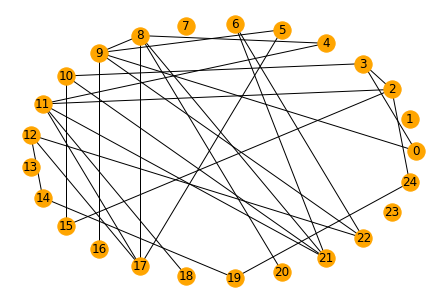

In [16]:
def nx_visualize(G):
    # Visualize the graph
    %matplotlib inline
    nx.draw_shell(G, with_labels=True, node_color='orange')

nx_visualize(G)

## 3. Initialization 

In [17]:
def random_walk(src, dest, min_step, neighbor_matrix):
    path=[src]
    #for i in range(step):
    while(True):
        next_node = random.choice(neighbor_matrix[path[-1]])
        path.append(next_node)
        
        if len(path) > min_step and path[-1] == dest:
            break
    return crossover.check_cycle(path)

In [18]:
def get_path_length(pop):
    # count path length of each individual
    path_length = []
    for ind in pop:
        path_length.append(len(ind))
    return path_length

In [19]:
def initial(G, s, d, iddfs_depth, population_size, neighbor_matrix):
    population = []
    for i in range(population_size):
        new_ind = random_walk(s, d, random_walk_mult * G.order(), neighbor_matrix)
        population.append(new_ind)
    return population

In [20]:
# Edge density of graph
# This is for calculating parameter (但現在還沒做)
edge_density = G.size()*2/G.order()*(G.order()-1)
print(edge_density)

55.67999999999999


In [ ]:
#candidate = np.linspace(0.1,0.2, num=2)
candidate = [10, 20, 50, 100, 150, 200]
fitness_for_plot = []
popsize_for_plot = []
for c in candidate:
    #population_size = min(200, max(int(ratio * edge_density), k_shortest))
    population_size = min(200,  max(c, k_shortest))
    popsize_for_plot.append(population_size)
    # for example, given src=0, dst=3, max_depth=7, population_size=20
    pop = initial(G, src, dst, max_depth, population_size, neighbor_matrix)
    print('-'*50)
    print('population_size: ', population_size)
    print('Path length for each initial individual:', get_path_length(pop))
    """
   # main loop
    fit_v_gen = []
    for g in range(generation):
        #display(pd.DataFrame(fitness.population_with_fitness(pop, bandwidth_matrix)))

        # crossover
        temp_pop = []
        for idx in range(len(pop)-1):
            child1, child2 = crossover.random_crossover(pop[idx], pop[idx+1], bandwidth_matrix)
            temp_child1 = crossover.check_cycle(child1)
            temp_child2 = crossover.check_cycle(child2)

            if len(temp_child1) != len(set(temp_child1)):
                print(child1, temp_child1)
                input()
            if len(temp_child2) != len(set(temp_child2)):
                print(child2, temp_child2)
                input()
            temp_pop += [temp_child1, temp_child2]

        # mutation
        children_pop = []
        for ind in pop:
            temp_child1 = mutation.mutation(neighbor_matrix, ind, 0.5)
            temp_child2 = crossover.check_cycle(temp_child1)
            if len(temp_child2) != len(set(temp_child2)):
                print(child2, temp_child2)
                input()
            children_pop.append(temp_child2)

        # diversity maintenance
        pop = np.unique(pop+temp_pop+children_pop).tolist()

        # fitness evaluation
        pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)

        # selection
        pop = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
        fit_v_gen.append(np.mean(pop['fitness'][:k_shortest]))
        #display(pop)
        pop = pop['individual'][0:population_size].tolist()

    pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
    rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
    rst['hop'] = get_path_length(pop)
    print("="*30)
    print(rst.head(k_shortest))
    print("="*30)
    
    # pareto front
    data = rst.drop(columns='individual').values
    front_idx = identify_pareto(data)
    pareto_front= data[front_idx]
    pareto_front.sort(axis=0)
    # construct figure
    fig = plt.figure(figsize=(6,4))

    # plot  data points
    plt.title("Pareto front ", fontsize=20)
    plt.scatter(rst['fitness'], rst['hop'])
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], color='r')

    # set plot metrics
    ylimit = [min(rst['hop'])-1, max(rst['hop'])+1]
    plt.ylim(ylimit)
    plt.xlabel('bottleneck bandwidth', fontsize=16)
    plt.ylabel('hop', fontsize=16).set_rotation(10)

    # Ref: https://stackoverflow.com/questions/9290938/how-to-set-my-xlabel-at-the-end-of-xaxis
    # Ref: https://stackoverflow.com/questions/37815976/setting-the-position-of-the-ylabel-in-a-matplotlib-graph
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.1,1.02)

    plt.show()
    
    # construct figure
    fig = plt.figure(figsize=(6,4))

    # plot data points
    plt.plot(fit_v_gen)
    fitness_for_plot.append(fit_v_gen)
    
    # set metrics
    plt.title("Average of top k fitness", fontsize=20)
    plt.xlabel('generation', fontsize=16)
    plt.ylabel('$\overline{fitness}$', fontsize=16, rotation=10)
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.07,1)

    plt.show()

    """


In [ ]:
fig = plt.figure(figsize=(8, 6))
for idx, _ in enumerate(fitness_for_plot):
    
    plt.plot(fitness_for_plot[idx])
    plt.legend(title='pop_size',labels=popsize_for_plot,  loc='best')
    
plt.show()

In [ ]:
pd.DataFrame(fitness_for_plot)

## 4. GA main loop

In [ ]:
pop, fit_v_gen = mainloop.mainloop(generation, pop, bandwidth_matrix, neighbor_matrix, k_shortest, population_size)

In [ ]:
# path length(hops) evaluation
pop_with_fit = fitness.population_with_fitness(pop, bandwidth_matrix)
rst = pd.DataFrame(sorted(pop_with_fit, key=lambda ind: ind['fitness'], reverse=True))
rst['hop'] = get_path_length(pop)
rst.head(k_shortest)

## 5. Plotting pareto-front

In [ ]:
data = rst.drop(columns='individual').values
pareto_front = plotting.plot_pareto(data)

In [ ]:
pareto_front

In [ ]:
rst

## 6. Plotting (top k) fitness vs. generation

In [ ]:
plotting.plot_fitness_vs_generation(fit_v_gen)

In [ ]:
max_band = max(bandwidth_matrix.flatten())
print(max_band)
print(np.where(bandwidth_matrix==max_band))

## Plot bandwidth distribution
$F(1,1)$: F-distribution with df1 = df2 = 1

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(6,4))
y = np.random.f(1, 1, 100) * 1000 + 1 
y = -np.sort(-y)
x = np.linspace(0, max(y), 100)

sns.distplot(y, ax=ax)
plt.show()

plt.plot(x,y)

plt.show()

## Exhausitve search (BFS)

In [ ]:
"""
all_path_generator = nx.all_simple_paths(G, src, dst)
max_bandwidth_path = pd.DataFrame(pop_with_fit).tail(k_shortest).values
current_max_bandwidth = min(max_bandwidth_path[:,0])

for p in all_path_generator:
    current_bandwidth = fitness.fitness(p, bandwidth_matrix) 
    if current_bandwidth > current_max_bandwidth:
        # create new pair of bandwidth & path
        temp = max_bandwidth_path[0].copy()
        temp[0] = current_bandwidth
        temp[1] = p
        # append to table with size k_shortest 
        max_bandwidth_path = np.append(max_bandwidth_path, [temp] , axis=0)
        if len(max_bandwidth_path) > k_shortest:
            max_bandwidth_path.sort(axis=0)
            max_bandwidth_path = max_bandwidth_path[0:-1]
        current_max_bandwidth = min(max_bandwidth_path[:,0])
        
print(max_bandwidth_path)
"""

In [ ]:
"""
max_bandwidth_path = pd.DataFrame(max_bandwidth_path, columns=['fitness', 'individual'])
# path length(hops) evaluation
max_bandwidth_path['hop'] = get_path_length(max_bandwidth_path['individual'].values)
max_bandwidth_path
"""